In [90]:
import itertools
import sys
from pathlib import Path
from typing import Any

import albumentations as A
from albumentations import ImageOnlyTransform
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

from dataset import BrainwaysDataset
from model import BrainwaysDinov2

In [102]:
device = torch.device('cuda')
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2 = dinov2.to(device)

Using cache found in /home/ben/.cache/torch/hub/facebookresearch_dinov2_main
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/ben/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:57<00:00, 21.2MB/s] 


In [79]:
class QuantileNormalization(ImageOnlyTransform):
    def __init__(
        self,
        min_quantile=0.0,
        max_quantile=1.0,
        always_apply=False,
        p=1.0,
    ):
        super().__init__(always_apply, p)
        self.min_quantile = min_quantile
        self.max_quantile = max_quantile

    def apply(self, image, **params):
        min_value, max_value = np.quantile(image, (self.min_quantile, self.max_quantile))
        return np.clip((image - min_value) / (max_value - min_value), a_min=0, a_max=1)

    def get_transform_init_args_names(self):
        return ("min_quantile", "max_quantile")

In [144]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

reference_image = (
    np.array(
        Image.open(
            "/home/ben/brainways/brainways-reg-model/data/real_raw/images/2018_retrograde/Retro3/Retro3_slide3"
            " [Scene #1 Channel #0].jpg"
        )
    )
    / 255
).astype(np.float32)

dataset = BrainwaysDataset(
    data_path=Path("/home/ben/brainways/brainways-reg-model/data/real/val"),
    atlas_name="whs_sd_rat_39um",
    transform=A.Compose(
        [
            # A.ElasticTransform(alpha=500, sigma=20, alpha_affine=0),
            A.Resize(448, 448),
            A.HistogramMatching(
                reference_images=[reference_image],
                blend_ratio=(1, 1),
                read_fn=lambda x: x,
                always_apply=True,
            ),
            # QuantileNormalization(0.1, 0.998),
            A.ToRGB(),
            A.FromFloat(dtype="uint8"),
            A.CLAHE(),
            A.ToFloat(),
            A.Normalize(mean=ADE_MEAN, std=ADE_STD),
            ToTensorV2(),
        ]
    ),
)

Bg_atlasapi: whs_sd_rat_39um version 1.0 is not the latest available (1.1). To update the atlas run in the 
terminal:
    brainglobe update -a whs_sd_rat_39um

In [145]:
W = 4
N = W**2
pca = PCA(n_components=3)
scaler = MinMaxScaler(clip=True)
patch_size = dinov2.patch_size

# 520//14
patch_h = 448 // patch_size
patch_w = 448 // patch_size

total_features = []
images = []
with torch.no_grad():
    for sample in itertools.islice(dataset, N):
        image = sample["image_a"]
        features_dict = dinov2.forward_features(
            image.to(device).unsqueeze(0)
        )
        features = features_dict["x_norm_patchtokens"]
        total_features.append(features)
        images.append(image)

total_features = torch.cat(total_features, dim=0)
feat_dim = total_features.shape[2]
total_features.shape

torch.Size([16, 1024, 1024])

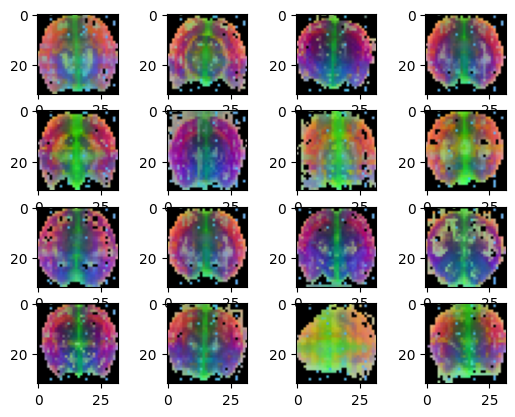

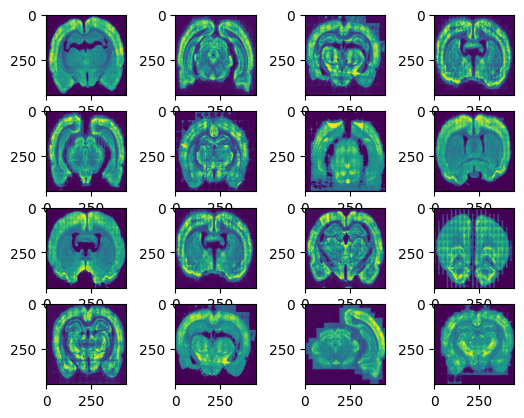

In [146]:
# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(N * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())

# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.6 # from first histogram
pca_features_fg = ~pca_features_bg

# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(N, patch_h, patch_w, 3)
for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

plt.figure()
for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(images[i][0])
plt.show()


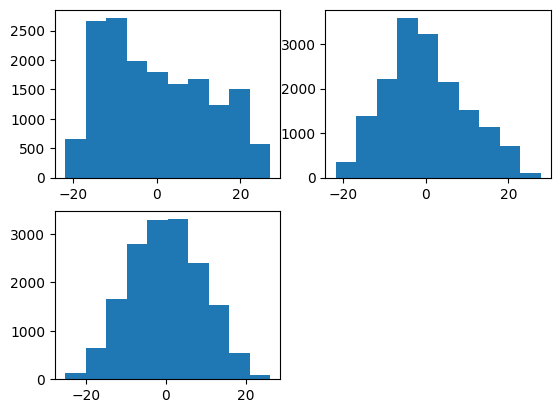

In [112]:
# First PCA to Seperate Background
# sklearn expects 2d array for traning
total_features = total_features.reshape(N * patch_h * patch_w, feat_dim) #4(*H*w, 1024)
total_features = total_features.cpu()

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

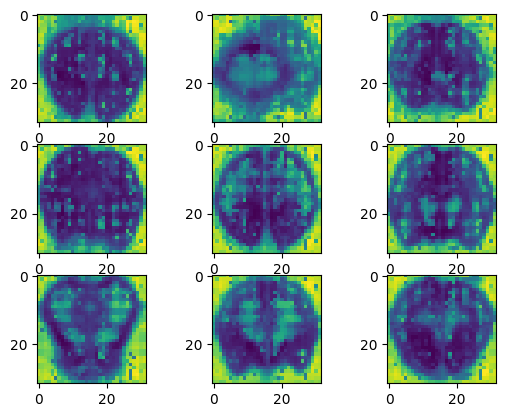

In [108]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
# pca_features = sklearn.processing.minmax_scale(pca_features)

for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

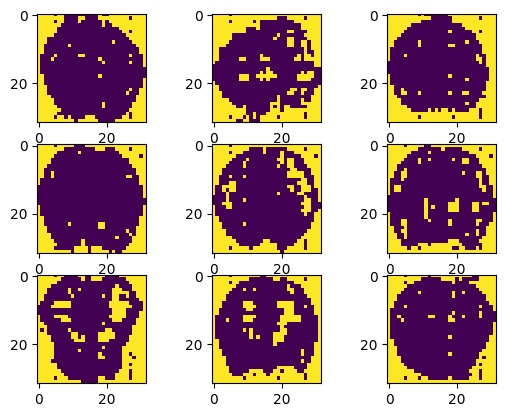

In [109]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.5 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

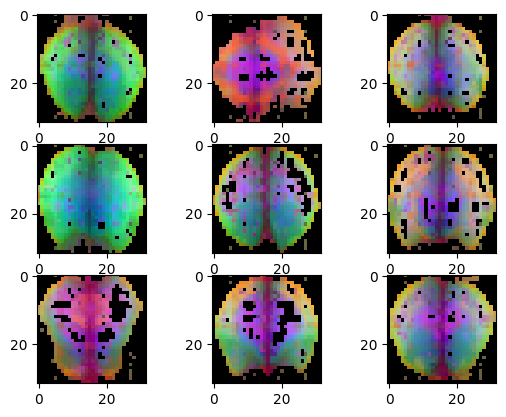

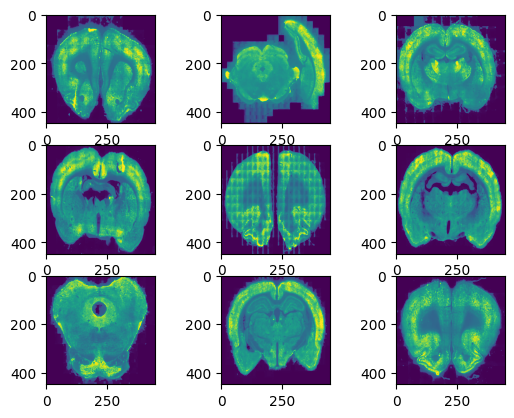

In [110]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
pca_features_rgb = pca_features_rgb.reshape(9, patch_h, patch_w, 3)
for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()

plt.figure()
for i in range(N):
    plt.subplot(W, W, i+1)
    plt.imshow(images[i][0])
plt.show()

